# **Time Series Prediction**

In [1]:
#importing neccessary function
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

#Statmodels
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

#other packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.8.0-py3-none-any.whl size=12587 sha256=93c0c330aed48fb7dc415676cd645889e3dd2aebc291686c9006416fc6fc0b31
  Stored in directory: /root/.cache/pip/wheels/ca/a9/1f/90c7a8a37ac37ff0fa0a27b2152f9b24be8910448ab93992f8
Successfully built empiricaldist
Downloaded thinkstats.py


In [2]:
#datasets and processing functions
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

#electricity dataset
elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")

#plotting functions
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    ax1 = plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2, sharex=ax1)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3, sharex=ax1)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4, sharex=ax1)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()


#dataset split
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

#evaluation
def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

Downloaded Net_generation_for_all_sectors.csv


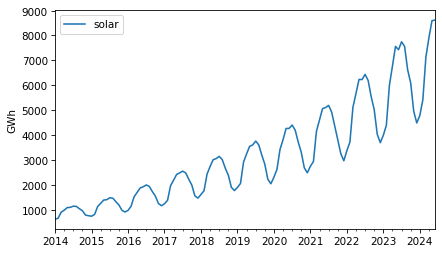

In [3]:
#Lets use a different dataset where the magnitude of the seasonal component and the residuals does not vary over time.

solar = elec["United States : small-scale solar photovoltaic"].dropna()
solar.plot(label="solar")
decorate(ylabel="GWh")

In [4]:
#dataset split
training, test = split_series(solar)

In [5]:
#this data is ideal for the multicative model
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(training, model="multiplicative", period=12)

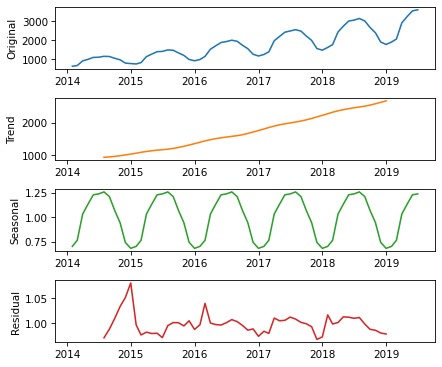

In [6]:
#plotting the decomposition
plot_decomposition(training, decomposition)

In [8]:
#computing the r-squared value
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

rsquared = 1 - resid.var() / training.var()
rsquared #confirming that solar is largely influenced by sunlight

0.9999999992978134

Prediction

In [10]:
import statsmodels.formula.api as smf

months = range(len(training))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months + I(months**2)", data=data).fit() #fits an ols model.. I(months**2) adds a quadratic term to the model, so we don't have to compute it explicitly

In [11]:
from thinkstats import display_summary

display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,766.1962,13.494,56.782,0.000,739.106,793.286
months,22.2153,0.938,23.673,0.000,20.331,24.099
I(months ** 2),0.1762,0.014,12.480,0.000,0.148,0.205


R-squared:,0.9983


In [14]:
#The p-values of the linear and quadratic terms are very small, which suggests that the quadratic model captures more information about the trend than a linear model would
#-- and the  R2  value is very high.

#making predictions
months = range(len(solar)) #extracts the months from the original data
df = pd.DataFrame({"months": months}) #put the arrray in a pd df
pred_trend = results.predict(df) #pass it to the predict methof
pred_trend.index = solar.index #changing the index to the same as the original

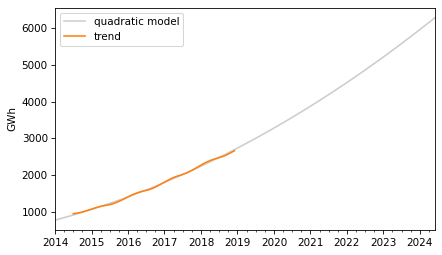

In [13]:
pred_trend.plot(color="0.8", label="quadratic model")
trend.plot(color="C1")
decorate(ylabel="GWh")

In [15]:
monthly_averages = seasonal.groupby(seasonal.index.month).mean()
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

In [16]:
pred = pred_trend * pred_seasonal

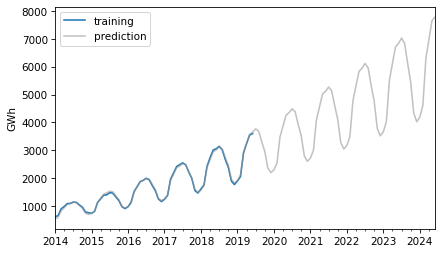

In [17]:
training.plot(label="training")
pred.plot(alpha=0.6, color="0.6", label="prediction")
decorate(ylabel="GWh")

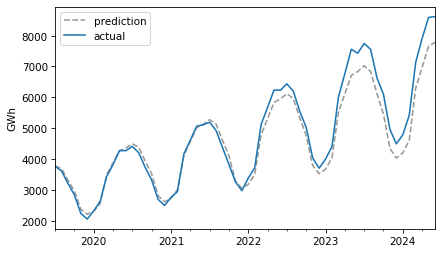

In [18]:
#plotting actual and predicted
future = pred[test.index]
future.plot(ls="--", color="0.6", label="prediction")

test.plot(label="actual")
decorate(ylabel="GWh")